```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 26b98e82e8d4e1ca2369cf735af8c7d3af460403 on branch reduced_gravity


# Sensitivy analysis of Barents Sea

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization, WindStress, Observation
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.dataassimilation import DataAssimilationUtils as dautils
from gpuocean.drifters import GPUDrifterCollection
#import animation_utils


In [4]:
%cuda_context_handler gpu_ctx

Path to the test file

In [5]:
source_url = "/sintef/data/NorFjords160/A12/norfjords_160m_his.nc4_2020020101-2020020200"
# source_url = "/lustre/storeB/project/fou/hi/NorFjords160/A12/norfjords_160m_his.nc4_2020020101-2020020200"

## Inspecting file structure and content

In [6]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 24, s_rho: 35, s_w: 36, eta_rho: 1271, xi_rho: 2051, eta_u: 1271, xi_u: 2050, eta_v: 1270, xi_v: 2051)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2020-02-01T01:00:00 ... 2020-02-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  # Remove the CWD from sys.path while we load stuff.


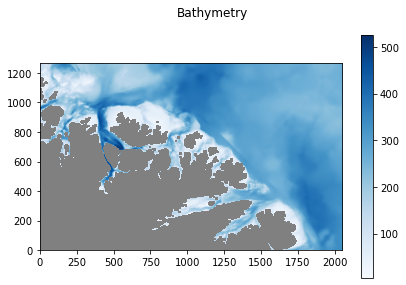

In [7]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][1:-1,1:-1], mask=(1-nc["mask_rho"][1:-1,1:-1]))

fig, ax = plt.subplots()
fig.suptitle("Bathymetry")

cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)
im = ax.imshow(H_m, cmap=cmap)

plt.colorbar(im, ax=ax)
plt.tight_layout()

In [8]:
[datetime.datetime.utcfromtimestamp(ocean_time).strftime('%Y-%m-%d %H:%M:%S') for ocean_time in nc["ocean_time"][:] ]

['2042-02-01 01:00:00',
 '2042-02-01 02:00:00',
 '2042-02-01 03:00:00',
 '2042-02-01 04:00:00',
 '2042-02-01 05:00:00',
 '2042-02-01 06:00:00',
 '2042-02-01 07:00:00',
 '2042-02-01 08:00:00',
 '2042-02-01 09:00:00',
 '2042-02-01 10:00:00',
 '2042-02-01 11:00:00',
 '2042-02-01 12:00:00',
 '2042-02-01 13:00:00',
 '2042-02-01 14:00:00',
 '2042-02-01 15:00:00',
 '2042-02-01 16:00:00',
 '2042-02-01 17:00:00',
 '2042-02-01 18:00:00',
 '2042-02-01 19:00:00',
 '2042-02-01 20:00:00',
 '2042-02-01 21:00:00',
 '2042-02-01 22:00:00',
 '2042-02-01 23:00:00',
 '2042-02-02 00:00:00']

## Generating GPUOcean Simulation from Input

In [9]:
dimY, dimX = ds.h.data.shape

In [10]:
x0, x1, y0, y1 = 1100, dimX-350, 315, dimY-585
t = 9
t_start = t
t_stop =  t_start + 6

T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]
print(timestep_indices)

[[9, 10, 11, 12, 13, 14, 15]]


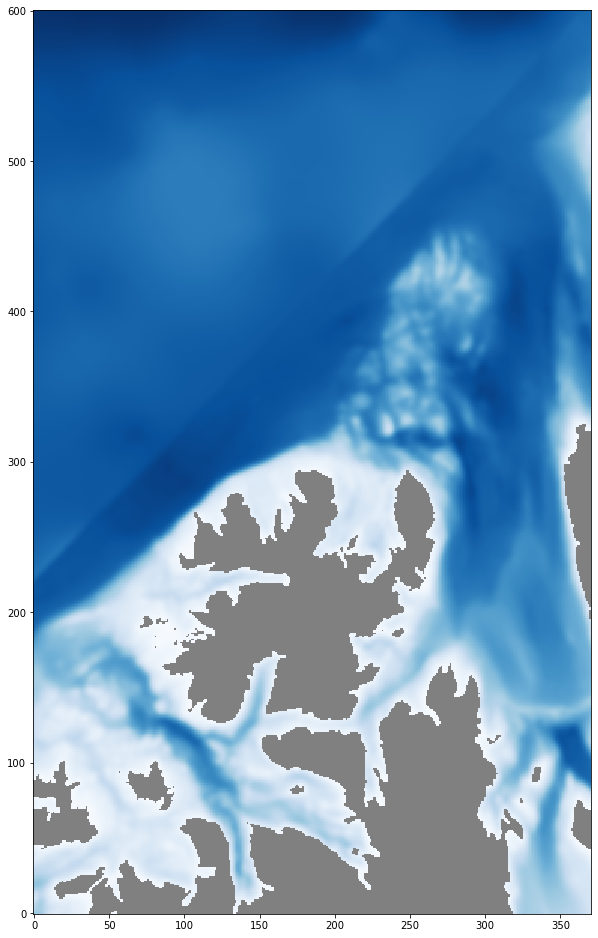

In [11]:
fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(np.flip(np.ma.array(nc["h"][y0:y1, x0:x1], mask = 1-nc["mask_rho"][y0:y1,x0:x1]), axis=0).T, interpolation="none", cmap="Blues", origin="lower")

### Reference arguments and sims

In [12]:
from importlib import reload
reload(NetCDFInitialization)

<module 'gpuocean.utils.NetCDFInitialization' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/NetCDFInitialization.py'>

In [13]:
ref_barotropic_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=timestep_indices, norkyst_data=False, land_value=5.0, download_data=False, )

In [14]:
ref_wind = ref_barotropic_data_args["wind"]

In [15]:
barotropic_ref_sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(ref_barotropic_data_args), dt=0.0, write_netcdf=False)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Investigate boundary condtions

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


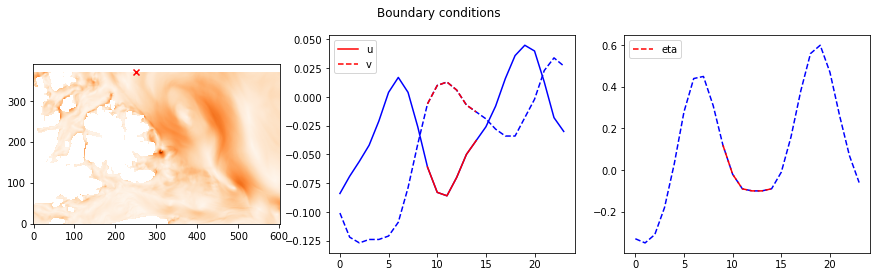

In [16]:
bcx = 250

fig, axs = plt.subplots(1,3,figsize=(15,4))
fig.suptitle("Boundary conditions")
axs[0].imshow(np.sqrt(nc["ubar"][0,y0:y1,x0:x1]**2 + nc["vbar"][0,y0:y1,x0:x1]**2), cmap=plt.cm.Oranges)
axs[0].scatter(bcx, y1-y0, marker="x", c="red")
axs[1].plot(np.arange(0,24),nc["ubar"][:,y0:y1,x0:x1][:,-1,bcx], c="blue")
axs[1].plot(np.arange(t_start,t_stop),nc["ubar"][:,y0:y1,x0:x1][t_start:t_stop,-1,bcx], c="red", label="u")
axs[1].plot(np.arange(0,24),nc["vbar"][:,y0:y1,x0:x1][:,-1,bcx], "--", c="blue")
axs[1].plot(np.arange(t_start,t_stop),nc["vbar"][:,y0:y1,x0:x1][t_start:t_stop,-1,bcx], "--", c="red", label="v")
axs[1].legend()
axs[2].plot(np.arange(0,24),nc["zeta"][:,y0:y1,x0:x1][:,-1,bcx], "--", c="blue")
axs[2].plot(np.arange(t_start,t_stop),nc["zeta"][:,y0:y1,x0:x1][t_start:t_stop,-1,bcx], "--", c="red", label="eta")
axs[2].legend()

### Perturbations 

In [17]:
# Wind 
def rotate_wind_field(wind, angle, plot=False):
    radians = (angle/360)*2*np.pi
    wind_u = wind.wind_u.copy()
    wind_v = wind.wind_v.copy()
    t = wind.t.copy()
    #print(t)

    c = np.cos(radians)
    s = np.sin(radians)
    wind_u_new = wind_u * c - wind_v * s
    wind_v_new = wind_u * s + wind_v * c

    if plot:
        x0, x1 = 200, 220
        y0, y1 = 200, 220

        fig = plt.figure()
        plt.quiver(wind_u[3, y0:y1, x0:x1], wind_v[3, y0:y1, x0:x1])

        fig = plt.figure()
        plt.quiver(wind_u_new[3, y0:y1, x0:x1], wind_v_new[3, y0:y1, x0:x1])
    return WindStress.WindStress(t=t, wind_u=wind_u_new, wind_v=wind_v_new)
       
#rotate_wind_field(ref_baroclinic_data_args['wind'], -45, plot=True)

wind_directions = np.arange(-20, 21, 5)
wind_samples = [None]*len(wind_directions)
print(wind_directions)
for i in range(len(wind_directions)):
    wind_samples[i] = rotate_wind_field(ref_wind, wind_directions[i])


[-20 -15 -10  -5   0   5  10  15  20]


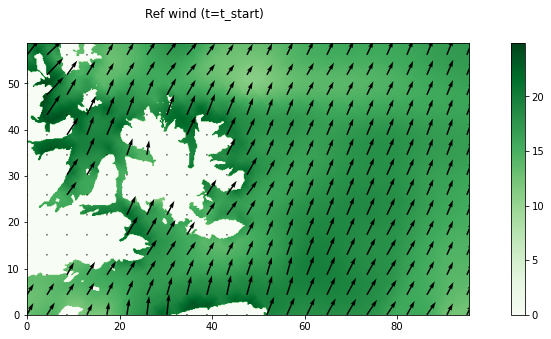

In [18]:
initV = np.ma.sqrt(ref_wind.wind_u[0]**2 + ref_wind.wind_v[0]**2)

frequency_x = 27
frequency_y = 27
x = np.arange(0, initV.shape[1], frequency_x)*barotropic_ref_sim.dx/1000
y = np.arange(0, initV.shape[0], frequency_y)*barotropic_ref_sim.dy/1000
qu = ref_wind.wind_u[0][::frequency_y, ::frequency_x]
qv = ref_wind.wind_v[0][::frequency_y, ::frequency_x]

domain_extent = [0, barotropic_ref_sim.nx*barotropic_ref_sim.dx/1000,
                     0, barotropic_ref_sim.ny*barotropic_ref_sim.dy/1000]

cmap_cp = copy.copy(plt.cm.Greens)
cmap_cp.set_bad("grey", alpha = 1.0)

fig, ax = plt.subplots(1,1,figsize=(15,5))
fig.suptitle("Ref wind (t=t_start)")

im = ax.imshow(initV, cmap=cmap_cp, extent=domain_extent, vmin=0.0)
plt.colorbar(im, ax=ax)

ax.quiver(x, y, qu, qv)


In [19]:
spinup_source_url = "/sintef/data/NorFjords160/A12/norfjords_160m_his.nc4_2020013101-2020020100"
# spinup_source_url = "/lustre/storeB/project/fou/hi/NorFjords160/A12/norfjords_160m_his.nc4_2020013101-2020020100"

In [20]:
# barotropic_spinup_data_args = []

# spinup_t = 12

# max_shift_t = 2

# for shift_t in range(-max_shift_t,max_shift_t+1):

#     if shift_t > 0:
#         spinup_source_url_list = [spinup_source_url, source_url]
#         spinup_timestep_indices = [np.arange(24-spinup_t, 24), np.arange(0,shift_t)]
#     elif shift_t <= 0:
#         spinup_source_url_list = [spinup_source_url]
#         spinup_timestep_indices = [np.arange(24-spinup_t+shift_t, 24+shift_t)]

#     spinup_data_args = NetCDFInitialization.getInitialConditions(spinup_source_url_list, x0, x1, y0, y1, timestep_indices=spinup_timestep_indices, norkyst_data=False, land_value=5.0, download_data=False)
#     spinup_data_args["eta0"] = ref_barotropic_data_args["eta0"].copy()
#     spinup_data_args["hu0"]  = ref_barotropic_data_args["hu0"].copy()
#     spinup_data_args["hv0"]  = ref_barotropic_data_args["hv0"].copy()
#     spinup_data_args["wind"] = ref_barotropic_data_args["wind"]

#     spinup_sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(spinup_data_args), dt=0.0)
#     spinup_sim.step(spinup_t*3600)
#     eta, hu, hv = spinup_sim.download()

#     spunup_barotropic_data_args = copy.copy(ref_barotropic_data_args)
#     spunup_barotropic_data_args["eta0"] = eta
#     spunup_barotropic_data_args["hu0"] = hu
#     spunup_barotropic_data_args["hv0"] = hv
#     barotropic_spinup_data_args.append(spunup_barotropic_data_args)
    

In [21]:
# from gpuocean.utils import PlotHelper

# fig, axs = plt.subplots(1, 2*max_shift_t+1, figsize=(25,3))
# fig.suptitle("Initial Velocity Fields (generated by spinup-with shifted tides)")

# Hm = nc["h"][y0:y1, x0:x1]

# for i in range(-max_shift_t, max_shift_t+1):

#     V = PlotHelper.genVelocity(barotropic_spinup_data_args[i]["eta0"] + Hm, 
#                             barotropic_spinup_data_args[i]["hu0"], barotropic_spinup_data_args[i]["hv0"])
#     V.mask = barotropic_spinup_data_args[i]["eta0"].mask

#     axs[i].imshow(V, cmap=plt.cm.Oranges, vmin=-0.5, vmax=0.5)

# Utility functions to run ensembles and plot variance and trajectories 

In [22]:
def run_sample(data_args_in, g=None, wind=None, wind_stress_factor=None, windage=0.0, friction=None, end_time=T, pert_init_drifter=False):
    data_args = copy.deepcopy(data_args_in)
    if g is not None:
        data_args["g"] = g
    if wind is not None:
        data_args["wind"] = wind
    if wind_stress_factor is not None:
        data_args["wind_stress_factor"] = wind_stress_factor
    if friction is not None:
        data_args["r"] = friction
    
    # Create sim
    sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(data_args),  dt=0.0)

    # Make observation object to log drift trajectory
    observation_type = dautils.ObservationType.UnderlyingFlow 
    observation_args = {'observation_type': observation_type,
                    'nx': sim.nx, 'ny': sim.ny,
                    'domain_size_x': sim.nx*sim.dx,
                    'domain_size_y': sim.ny*sim.dy,
                    'land_mask': sim.getLandMask()
                    }
    trajectories = Observation.Observation(**observation_args)

    # Create and initialize drifter objects
    initx = [47500, 60000, 72500, 80000, 72500, 50000, 30000]
    inity = [42500, 30500, 37500, 27500, 15000,  7500,  5000]   

    num_drifters = len(initx)

    if pert_init_drifter:
        initx += np.random.normal(scale=100, size=num_drifters)
        inity += np.random.normal(scale=100, size=num_drifters)

    drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                        boundaryConditions = sim.boundary_conditions,
                                                        domain_size_x = trajectories.domain_size_x,
                                                        domain_size_y = trajectories.domain_size_y,
                                                        gpu_stream = sim.gpu_stream,
                                                        wind=data_args["wind"],
                                                        wind_drift_factor = windage
                                                        )

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)

    # Attach drifters and log init position
    sim.attachDrifters(drifters)
    trajectories.add_observation_from_sim(sim)

    # Simulation loop, logging drifter positions every 2 min
    drifter_log_dt = 2*60
    t = 0
    while t < end_time:
        dt = min(drifter_log_dt, end_time - t)
        sim.step(dt)
        t = t + dt
        trajectories.add_observation_from_sim(sim)

    # return final ocean state and trajectory
    eta, hu, hv = sim.download()
    return {"eta": eta, "hu": hu, "hv": hv, "trajectories": trajectories}


In [23]:

def _get_statistics(results, ref_sim):
    N = len(results)
    etas = np.zeros((N, results[0]["eta"].shape[0], results[0]["eta"].shape[1]))
    hus  = np.zeros((N, results[0]["hu"].shape[0],  results[0]["hu"].shape[1]))
    hvs  = np.zeros((N, results[0]["hv"].shape[0],  results[0]["hv"].shape[1]))
    for i in range(N):
        etas[i,:,:] = results[i]["eta"]
        hus[i,:,:] = results[i]["hu"]
        hvs[i,:,:] = results[i]["hv"]

    _, Hm = ref_sim.downloadBathymetry()


    v = np.sqrt((hus/(etas + Hm))**2 + (hvs/(etas + Hm))**2)

    mean_eta = np.ma.MaskedArray(np.mean(etas, axis=0), mask=results[0]["eta"].mask)
    mean_v   = np.ma.MaskedArray(np.mean(v,    axis=0), mask=results[0]["eta"].mask)
    var_eta  = np.ma.MaskedArray(np.var(etas,  axis=0), mask=results[0]["eta"].mask)
    var_v    = np.ma.MaskedArray(np.var(v,     axis=0), mask=results[0]["eta"].mask)


    return mean_eta, mean_v, var_eta, var_v


def _plot_field(results, field, ref_sim, T, title=None, plot_trajectories=True, 
                cmap=plt.cm.Reds, vmin=0.0, vmax=0.5, filename=None, cbar=True, cbar_label=None, zoom=[0,None,0,None],
                quiver=None):
    
    with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(15,5))

        zoom_x0, zoom_x1, zoom_y0, zoom_y1 = zoom

        if zoom_x1 is None:
            dom_x1 = ref_sim.nx
        else:
            dom_x1 = zoom_x1
        if zoom_y1 is None:
            dom_y1 = ref_sim.ny
        else:
            dom_y1 = zoom_y1
        domain_extent = [zoom_x0*ref_sim.dx/1000, dom_x1*ref_sim.dx/1000, zoom_y0*ref_sim.dy/1000, dom_y1*ref_sim.dy/1000]

        cmap_cp = copy.copy(cmap)
        cmap_cp.set_bad("grey", alpha = 1.0)

        im = ax.imshow(field[zoom_y0:zoom_y1, zoom_x0:zoom_x1], interpolation="none", origin='lower', 
                       cmap=cmap_cp, 
                       vmin=vmin, vmax=vmax, 
                       extent=domain_extent)
        
        try:
            lat = np.array(nc.variables["lat_rho"])
            lon = np.array(nc.variables["lon_rho"])

            spec_lat = lat[y0:y1, x0:x1]
            spec_lon = lon[y0:y1, x0:x1]

            cont_lon_case = ax.contour(spec_lon, levels = np.arange(20, 30, 0.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8)
            cont_lat_case = ax.contour(spec_lat, levels = np.arange(65, 75, 0.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8)

        except Exception as e:
            raise e

        ax.tick_params(axis='both', which='major', labelsize=28)

        if plot_trajectories:
            num_drifters = results[0]["trajectories"].get_num_drifters()
            for d in range(num_drifters):
                for i in range(len(results)):
                    drifter_path = results[i]["trajectories"].get_drifter_path(d, 0, T, in_km = True)[0]
                    start_pos = drifter_path[0,:]

                    if (domain_extent[0] < start_pos[0] < domain_extent[1]) and (domain_extent[2] < start_pos[1] < domain_extent[3]):
                        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                                        0.01, color = 'black',
                                                                        fill=True, zorder=10)
                        ax.add_patch(circ_start)
                        
                        drifter_pathX = np.minimum(np.maximum(domain_extent[0], drifter_path[:,0]),domain_extent[1])
                        drifter_pathY = np.minimum(np.maximum(domain_extent[2], drifter_path[:,1]),domain_extent[3])
                        ax.plot(drifter_pathX, drifter_pathY, color="C0", ls="-", zorder=5)
            
                        end_pos = drifter_path[-1,:]
                        if (domain_extent[0] < end_pos[0] < domain_extent[1]) and (domain_extent[2] < end_pos[1] < domain_extent[3]):
                            ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=100, linewidths=2)

        if quiver is not None:
            ax.quiver(quiver[0], quiver[1], quiver[2], quiver[3], scale=5)

        if cbar:
            cb = plt.colorbar(im, ax=ax, shrink=0.75, pad=0.075) #, shrink=0.8)
            cb.ax.tick_params(labelsize=28)
            cb.formatter.set_powerlimits((-2, 2))
            cb.formatter.set_useMathText(True)
            cb.ax.yaxis.offsetText.set_fontsize(24)

        if cbar and cbar_label is not None:
            cb.set_label(label=cbar_label, size=24, labelpad=25)

        if title is not None:
            plt.title(title+"\n", fontsize=16)
        
        plt.tight_layout()

        if filename is not None:
            folder = "barents_sensitivity_figs"
            os.makedirs(folder, exist_ok=True)
            plt.savefig(os.path.join(folder, "barents_"+filename+".pdf"), bbox_inches="tight", dpi=800)


def plot_drifters_and_variance(results, ref_sim, T, suptitle=None, filename=None, vmax=None, cbar=True, cbar_label=None, zoom=[0, None, 0, None]):
    # results are list with dicts [{eta, hu, hv, trajectories}]

    mean_eta, mean_vel, var_eta, var_vel = _get_statistics(results, ref_sim)

    if vmax is None:
        vmax = max(var_vel.max()/4, 1e-6)

    _plot_field(results, var_vel, ref_sim, T, title=suptitle, vmin=0, vmax=vmax, filename=filename, cbar=cbar, cbar_label=cbar_label,  zoom=zoom)
    #_plot_field(results, var_eta, ref_sim, T, "MLD variance", vmin=0, vmax=4)
    
    print("Maximum velocity: ", mean_vel.max(), var_vel.max())

#plot_drifters_and_variance(mld_dens_results, ref_sim, T, "Perturbing MLD init")

# Plot initial positions of the drifters with annotations

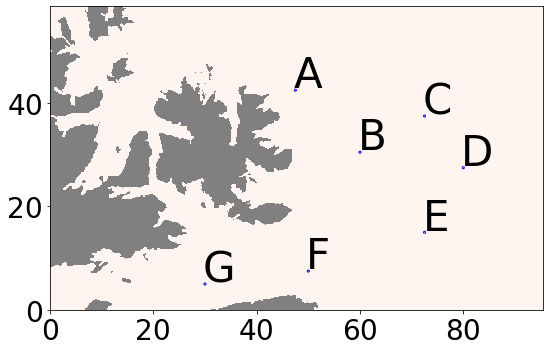

In [24]:
initx = [47500, 60000, 72500, 80000, 72500, 50000, 30000]
inity = [42500, 30500, 37500, 27500, 15000,  7500,  5000]

from string import ascii_uppercase as auc

with plt.rc_context({'lines.color':'black', 
                    'text.color':'black', 
                    'axes.labelcolor':'black', 
                    'xtick.color':'black',
                    'ytick.color':'black'}):
    fig, ax = plt.subplots(1,1, figsize=(15,5))

    domain_extent = [0, barotropic_ref_sim.nx*barotropic_ref_sim.dx/1000,
                     0, barotropic_ref_sim.ny*barotropic_ref_sim.dy/1000]

    cmap_cp = copy.copy(plt.cm.Reds)
    cmap_cp.set_bad("grey", alpha = 1.0)
    background_field = np.zeros_like(ref_barotropic_data_args["eta0"])

    im = ax.imshow(background_field, interpolation="none", origin='lower', 
                cmap=cmap_cp, 
                extent=domain_extent)
    
    ax.tick_params(axis='both', which='major', labelsize=28)

    for d in range(len(initx)):
        circ_start = matplotlib.patches.Circle((initx[d]/1000, inity[d]/1000), 
                                                0.2, color = 'blue',
                                                fill=False, zorder=10)
        ax.add_patch(circ_start)

        
        ax.annotate(auc[d],[initx[d]/1000-0.4, inity[d]/1000+0.5], fontsize=42 )



    # plt.title("Initial drifter positions\n", fontsize=16)
    plt.tight_layout()

    if True:
        folder = "barents_sensitivity_figs"
        os.makedirs(folder, exist_ok=True)
        plt.savefig(os.path.join(folder, "barents_initial_drifter_positions.pdf"), bbox_inches="tight", dpi=800)



# Run eperiments and plot results

Barotropic reference

In [25]:
ref_barotropic_result = [run_sample(ref_barotropic_data_args)]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


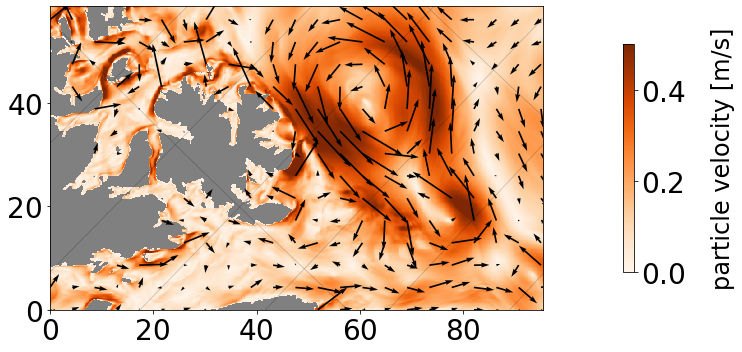

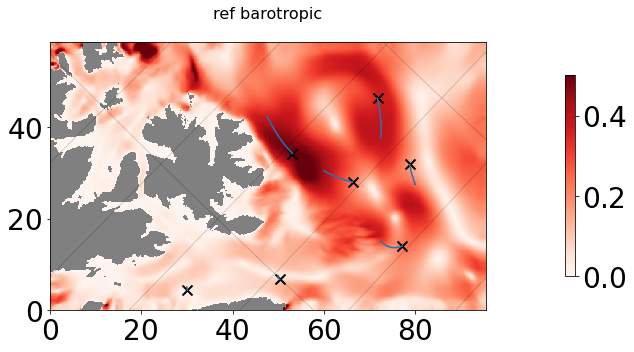

In [26]:
initV = np.ma.sqrt((ref_barotropic_data_args["hu0"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2 + (ref_barotropic_data_args["hv0"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2)

frequency_x = 27
frequency_y = 27
x = np.arange(0, initV.shape[1], frequency_x)*barotropic_ref_sim.dx/1000
y = np.arange(0, initV.shape[0], frequency_y)*barotropic_ref_sim.dy/1000
qu = (ref_barotropic_data_args["hu0"]/barotropic_ref_sim.downloadBathymetry()[1])[::frequency_y, ::frequency_x]
qv = (ref_barotropic_data_args["hv0"]/barotropic_ref_sim.downloadBathymetry()[1])[::frequency_y, ::frequency_x]

_plot_field(ref_barotropic_result, initV, barotropic_ref_sim, T, filename="init_barotropic", plot_trajectories=False, cbar_label="particle velocity [m/s]", cmap=plt.cm.Oranges, quiver=[x,y,qu,qv])


refV = np.ma.sqrt((ref_barotropic_result[0]["hu"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2 + (ref_barotropic_result[0]["hv"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2)
_plot_field(ref_barotropic_result, refV, barotropic_ref_sim, T, "ref barotropic", plot_trajectories=True)

#### Shifted BC

In [27]:
# max_shift_t = 2

# tide_shifted_data_args = []

# for shift_t in range(-max_shift_t,max_shift_t+1):

#     spinup_source_url_list = [source_url]
#     spinup_timestep_indices = [np.arange(t_start+shift_t, t_stop+shift_t)]

#     tide_shifted_data_args_i = copy.copy(ref_barotropic_data_args)
#     tide_shifted_data_args_i["boundary_conditions_data"] = NetCDFInitialization.getInitialConditions(spinup_source_url_list, x0, x1, y0, y1, timestep_indices=spinup_timestep_indices, norkyst_data=False, land_value=5.0, download_data=False)["boundary_conditions_data"]

#     tide_shifted_data_args.append(tide_shifted_data_args_i)

In [28]:
# shifted_results = [None]*len(tide_shifted_data_args)
# for i in range(len(tide_shifted_data_args)):
#     shifted_results[i] = run_sample(tide_shifted_data_args[i], wind=ref_wind)

In [29]:
# plot_drifters_and_variance(shifted_results, barotropic_ref_sim, T, filename="tideshifted", cbar=False, vmax=5*1e-3)

In [30]:
max_shift_t = 9

time_shifted_data_args = []

for shift_t in range(-max_shift_t,max_shift_t):

    shifted_timestep_indices = [np.arange(t_start+shift_t, t_stop+shift_t+1)]
    time_shifted_data_args_i = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=shifted_timestep_indices, norkyst_data=False, land_value=5.0, download_data=False)

    time_shifted_data_args.append(time_shifted_data_args_i)

In [31]:
shifted_results = [None]*len(time_shifted_data_args)
for i in range(len(time_shifted_data_args)):
    shifted_results[i] = run_sample(time_shifted_data_args[i], wind=ref_wind)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  1.1590685872795734 0.0810921488729228


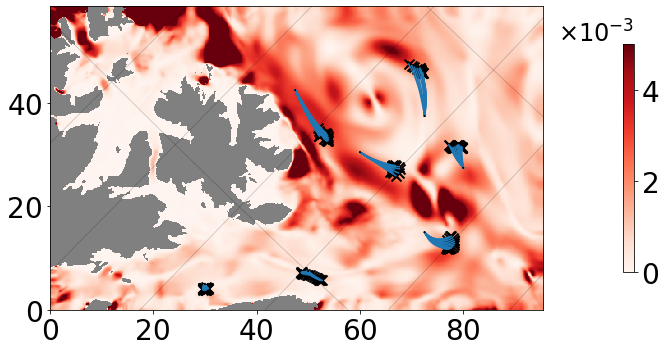

In [32]:
plot_drifters_and_variance(shifted_results, barotropic_ref_sim, T, filename="timeshifted", cbar=True, vmax=5e-3)

### Windage - wind contribution on advection

In [41]:
windage_samples = np.arange(0.0, 0.051, 0.005)

In [42]:
windage_results = [None]*len(windage_samples)
for i in range(len(windage_samples)):
    windage_results[i] = run_sample(ref_barotropic_data_args, wind=ref_wind, windage=windage_samples[i])


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  1.1650744962752353 1.1093356479670479e-31


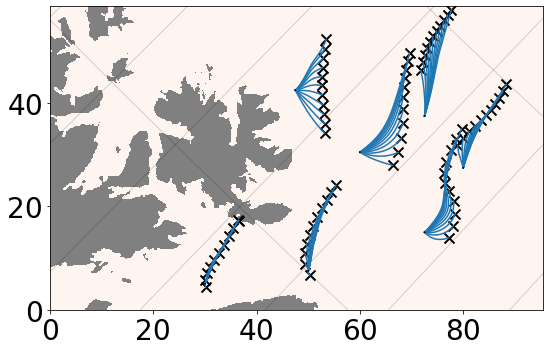

In [43]:
plot_drifters_and_variance(windage_results, barotropic_ref_sim, T, filename="windage", cbar=False, vmax=5e-3)

### Wind direction

In [36]:
barotropic_wind_direction_results = [None]*len(wind_samples)
barotropic_wind_direction_results_no_windage = [None]*len(wind_samples)
for i in range(len(wind_samples)):
    barotropic_wind_direction_results[i] = run_sample(ref_barotropic_data_args, wind=wind_samples[i], windage=0.03)
    barotropic_wind_direction_results_no_windage[i] = run_sample(ref_barotropic_data_args, wind=wind_samples[i], windage=0)


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  1.16507279396691 0.006905626009770601


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  1.16507279396691 0.006905626009770601


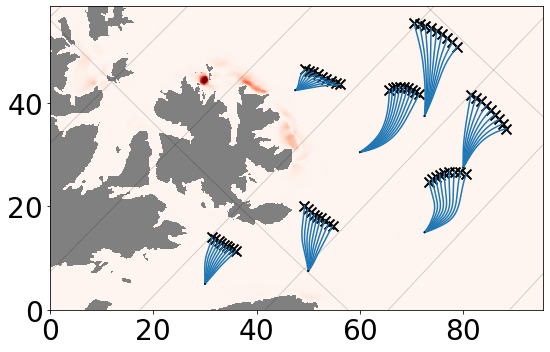

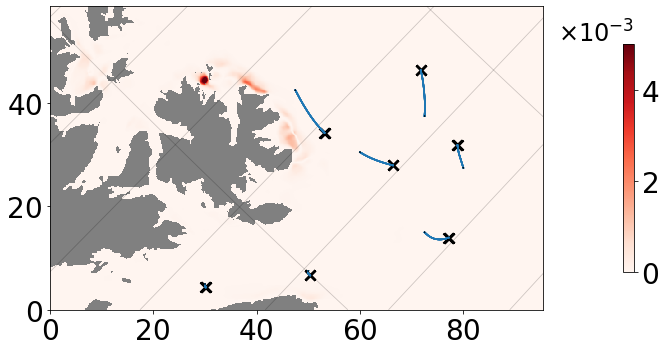

In [37]:
plot_drifters_and_variance(barotropic_wind_direction_results, barotropic_ref_sim, T, filename="wind_direction", vmax=5e-3, cbar=False)
plot_drifters_and_variance(barotropic_wind_direction_results_no_windage, barotropic_ref_sim, T, filename="wind_direction_nowindage", vmax=5e-3)